# Importing dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.mobilenet import MobileNet, preprocess_input 
from keras.losses import categorical_crossentropy

# build model

In [2]:
base_model = MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze backbone
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(units=7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [3]:
from tensorflow.keras.optimizers import Adam
for layer in base_model.layers[-30:]:
    layer.trainable = True
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)




# Get data

In [ ]:



train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)



train_data = train_datagen.flow_from_directory(
    directory=r"/kaggle/input/emotion-detection-fer/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)


print(train_data.class_indices)   # dictionary of class labels
print("Total images found:", train_data.samples)


Found 28709 images belonging to 7 classes.
{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
Total images found: 28709


In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))


In [7]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_data = val_datagen.flow_from_directory(
    directory=r"/kaggle/input/emotion-detection-fer/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)


Found 7178 images belonging to 7 classes.


In [8]:
print("Train classes:", train_data.class_indices)
print("Validation classes:", val_data.class_indices)

print("Train samples:", train_data.samples)
print("Validation samples:", val_data.samples)


Train classes: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
Validation classes: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
Train samples: 28709
Validation samples: 7178


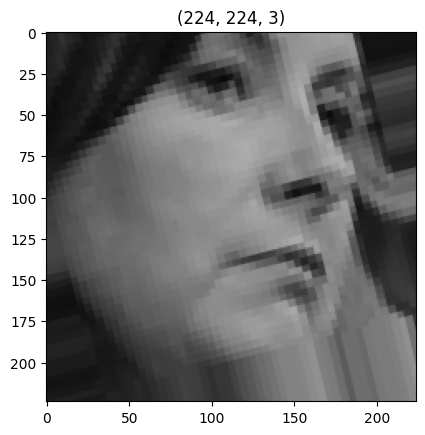

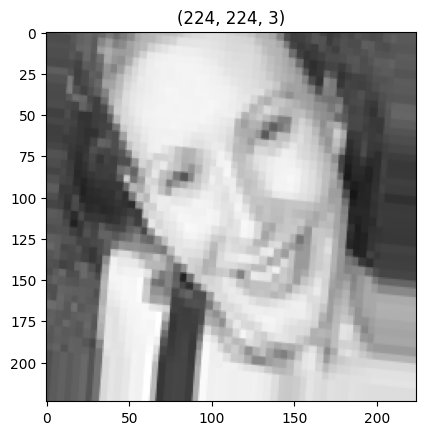

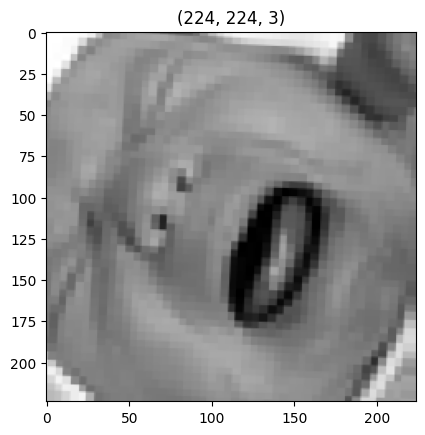

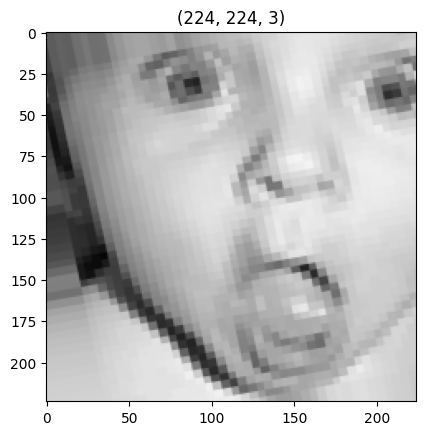

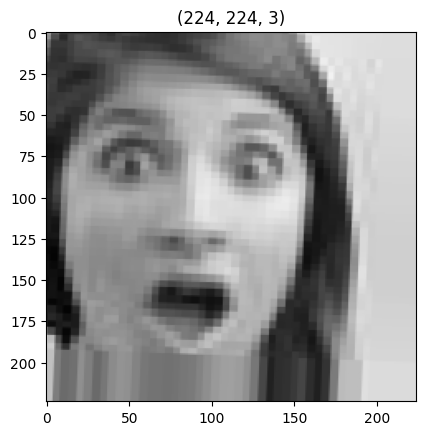

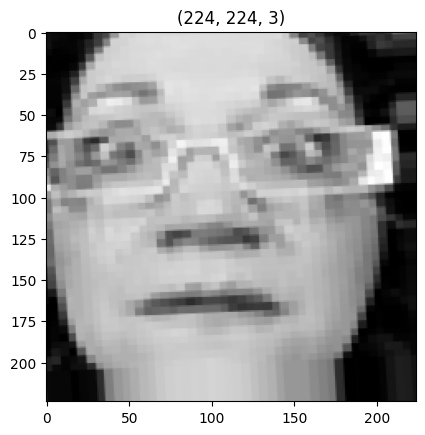

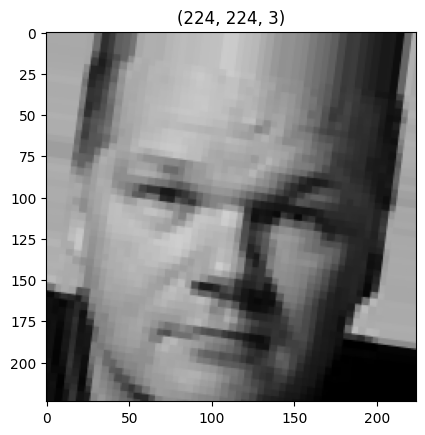

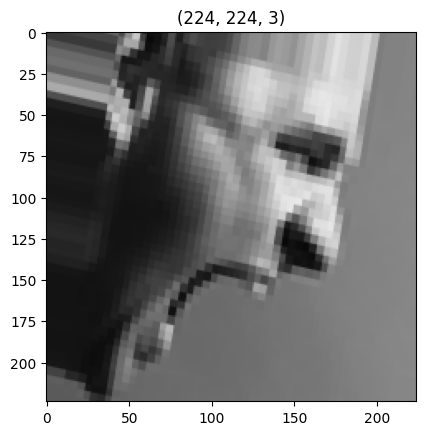

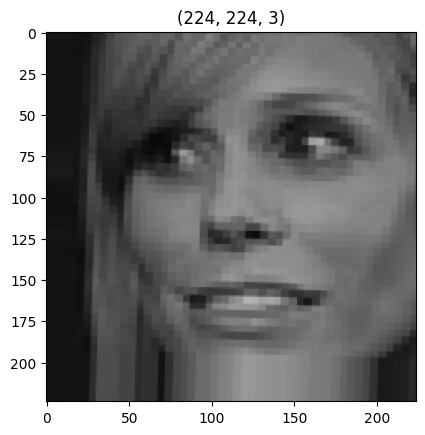

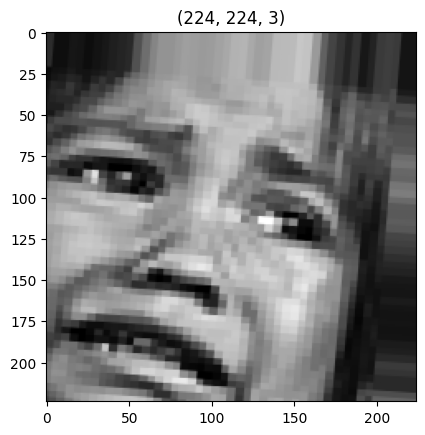

In [9]:
t_img, label = next(train_data)


def plotImages(img_arr, label):
  """
  input  :- images array 
  output :- plots the images 
  """
  count = 0
  for im, l in zip(img_arr,label) :
    plt.imshow(im)
    plt.title(im.shape)
    plt.axis = False
    plt.show()
    
    count += 1
    if count == 10:
      break


plotImages(t_img, label)



In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(
    monitor='val_loss',          # smoother signal
    min_delta=0.001,             # tiny improvement counts
    patience=10,                 # give model time
    verbose=1,
    restore_best_weights=True
)

m_ch = ModelCheckpoint(
    filepath="best_model.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)

callbacks = [es, m_ch]


In [11]:
hist = model.fit(
    train_data,
    steps_per_epoch=30,
    epochs=50,
    validation_data=val_data,
    validation_steps=8,
    callbacks=[es, m_ch]
)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.1669 - loss: 2.4071
Epoch 1: val_loss improved from None to 3.03015, saving model to best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 852ms/step - accuracy: 0.1969 - loss: 2.2608 - val_accuracy: 0.0039 - val_loss: 3.0302
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.2919 - loss: 1.9145
Epoch 2: val_loss improved from 3.03015 to 2.60363, saving model to best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 791ms/step - accuracy: 0.2927 - loss: 1.8833 - val_accuracy: 0.0312 - val_loss: 2.6036
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.3175 - loss: 1.7702
Epoch 3: val_loss did not improve from 2.60363
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 788ms/step - accuracy: 0.3271 - loss: 1.7731 - val_accuracy: 0.0000e+00 - val_loss: 2.9991
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.3500 - loss: 1.7305
Epoch 4: val_loss improved from 2.60363 to 2.36985, saving model to best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 765ms/step - accuracy: 0.3521 - loss: 1.7255 - val_accuracy: 0.0430 - val_loss: 2.3698
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.4013 - loss: 1.5557
Epoch 5: val_loss improved from 2.36985 to 2.26772, saving model to best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 785ms/step - accuracy: 0.3906 - loss: 1.5757 - val_accuracy: 0.0625 - val_loss: 2.2677
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.3757 - loss: 1.6452
Epoch 6: val_loss did not improve from 2.26772
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 755ms/step - accuracy: 0.3917 - loss: 1.6254 - val_accuracy: 0.0625 - val_loss: 2.2876
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.4261 - loss: 1.5177
Epoch 7: val_loss improved from 2.26772 to 1.70892, saving model to best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 766ms/step - accuracy: 0.4083 - loss: 1.5548 - val_accuracy: 0.2148 - val_loss: 1.7089
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.4272 - loss: 1.5268
Epoch 8: val_loss did not improve from 1.70892
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 763ms/step - accuracy: 0.4365 - loss: 1.4992 - val_accuracy: 0.2031 - val_loss: 1.8068
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.4679 - loss: 1.4335
Epoch 9: val_loss did not improve from 1.70892
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 775ms/step - accuracy: 0.4719 - loss: 1.4094 - val_accuracy: 0.2070 - val_loss: 1.8257
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.4861 - loss: 1.3999
Epoch 10: val_loss improved from 1.70892 to 1.60457, saving model to best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 773ms/step - accuracy: 0.4729 - loss: 1.4084 - val_accuracy: 0.2930 - val_loss: 1.6046
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.4707 - loss: 1.4346
Epoch 11: val_loss did not improve from 1.60457
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 770ms/step - accuracy: 0.4437 - loss: 1.4456 - val_accuracy: 0.1836 - val_loss: 1.8481
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.4689 - loss: 1.4231
Epoch 12: val_loss did not improve from 1.60457
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 778ms/step - accuracy: 0.4635 - loss: 1.4338 - val_accuracy: 0.2852 - val_loss: 1.6545
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.5240 - loss: 1.3607
Epoch 13: val_loss improved from 1.60457 to 1.27166, saving model to best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 788ms/step - accuracy: 0.4969 - loss: 1.3945 - val_accuracy: 0.4336 - val_loss: 1.2717
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.5343 - loss: 1.2985
Epoch 14: val_loss did not improve from 1.27166
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 761ms/step - accuracy: 0.5292 - loss: 1.2866 - val_accuracy: 0.4375 - val_loss: 1.3297
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.4951 - loss: 1.3371
Epoch 15: val_loss did not improve from 1.27166
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 761ms/step - accuracy: 0.4812 - loss: 1.3640 - val_accuracy: 0.2969 - val_loss: 1.5959
Epoch 16/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.4495 - loss: 1.4025
Epoch 16: val_loss did not improve from 1.27166
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 778ms/step - accuracy: 0.4896 - loss: 1.3478 - val_accuracy: 0.3984 - val_loss: 1.4827
Epoch 17/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.5176 - loss: 1.3244
Epoch 17: val_loss did not improve f

30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 787ms/step - accuracy: 0.5271 - loss: 1.2413 - val_accuracy: 0.5195 - val_loss: 1.2516
Epoch 23/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.5344 - loss: 1.2320
Epoch 23: val_loss did not improve from 1.25155
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 784ms/step - accuracy: 0.5354 - loss: 1.2371 - val_accuracy: 0.5078 - val_loss: 1.3058
Epoch 24/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.5436 - loss: 1.2846
Epoch 24: val_loss did not improve from 1.25155
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 801ms/step - accuracy: 0.5302 - loss: 1.2773 - val_accuracy: 0.4727 - val_loss: 1.3202
Epoch 25/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.5174 - loss: 1.2842
Epoch 25: val_loss did not improve from 1.25155
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 780ms/step - accuracy: 0.5146 - loss: 1.2666 - val_accuracy: 0.4766 - val_loss: 1.3801
Epoch 26/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.5911 - loss: 1.1247
Epoch 26: val_loss did not improve f

30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 787ms/step - accuracy: 0.5562 - loss: 1.2108 - val_accuracy: 0.6680 - val_loss: 0.9556
Epoch 29/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.5159 - loss: 1.2742
Epoch 29: val_loss did not improve from 0.95565
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 785ms/step - accuracy: 0.5490 - loss: 1.2230 - val_accuracy: 0.6289 - val_loss: 1.0682
Epoch 30/50
28/30 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step - accuracy: 0.5533 - loss: 1.1978

C:\Users\maria\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 30: val_loss did not improve from 0.95565
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 754ms/step - accuracy: 0.5502 - loss: 1.1952 - val_accuracy: 0.6328 - val_loss: 1.0349
Epoch 31/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.5411 - loss: 1.2268
Epoch 31: val_loss did not improve from 0.95565
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 810ms/step - accuracy: 0.5458 - loss: 1.2104 - val_accuracy: 0.6016 - val_loss: 1.1044
Epoch 32/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.5545 - loss: 1.1667
Epoch 32: val_loss did not improve from 0.95565
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 823ms/step - accuracy: 0.5615 - loss: 1.1473 - val_accuracy: 0.6289 - val_loss: 1.0582
Epoch 33/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.5753 - loss: 1.1183
Epoch 33: val_loss did not improve from 0.95565
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 789ms/step - accuracy: 0.5802 - loss: 1.1382 - val_accuracy: 0.6250 - val_loss: 1.0664
Epoch 34/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.5665 - 

30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 796ms/step - accuracy: 0.5719 - loss: 1.1758 - val_accuracy: 0.7266 - val_loss: 0.8742
Epoch 35/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.5871 - loss: 1.1522
Epoch 35: val_loss did not improve from 0.87420
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 785ms/step - accuracy: 0.5979 - loss: 1.1125 - val_accuracy: 0.6641 - val_loss: 1.0005
Epoch 36/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.5749 - loss: 1.1379
Epoch 36: val_loss did not improve from 0.87420
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 792ms/step - accuracy: 0.5823 - loss: 1.1259 - val_accuracy: 0.6445 - val_loss: 1.0780
Epoch 37/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.5547 - loss: 1.1439
Epoch 37: val_loss did not improve from 0.87420
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 781ms/step - accuracy: 0.5437 - loss: 1.1796 - val_accuracy: 0.5156 - val_loss: 1.2028
Epoch 38/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.5388 - loss: 1.1697
Epoch 38: val_loss did not improve f

In [13]:
from keras.models import load_model
model=load_model(r"C:\Users\maria\OneDrive\Desktop\CV project\Emotion_detection\best_model.h5")

In [14]:
his=hist.history
his.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

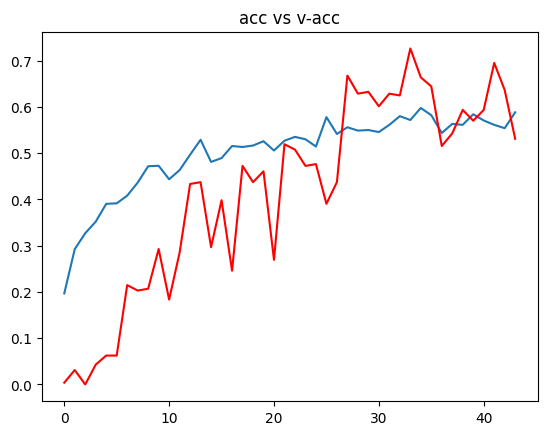

In [15]:
plt.plot(his['accuracy'])
plt.plot(his['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

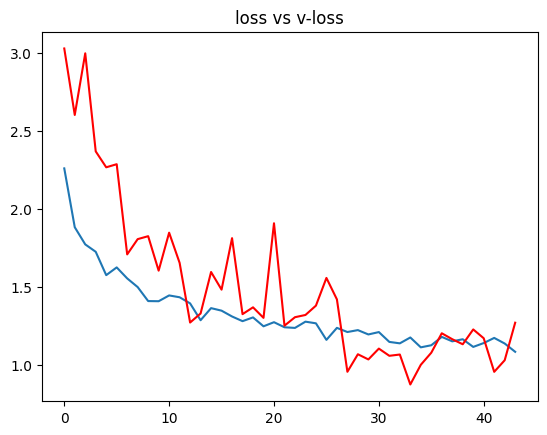

In [16]:

plt.plot(his['loss'])
plt.plot(his['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

In [17]:
op=dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
 the image is of happy


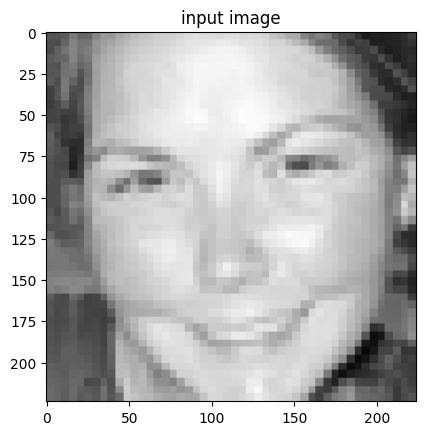

In [18]:
path=r"train\happy\im1.png"
img = load_img(path, target_size=(224,224) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f" the image is of {op[pred]}")

# to display the image  
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()